#**Introduction to Clinical DataScience**   
##Exersice 2  
##**Mortality prediction**  
###by Alex Romanovskii (342569985)

We import some standard python data analysis packages and do authentication on Google Drive 

In [ ]:
from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Next we will need to enter some information on how to access the data.

*analysis_project* is the project used for processing the queries.

In [ ]:
#@title Fill out this form then press [shift ⇧]+[enter ⏎] {run: "auto"}
import subprocess
import re

analysis_project = 'physionet-data-275415'  #@param {type:"string"}

admissions_table = 'physionet-data.mimiciii_clinical.admissions'  # @param {type: "string"}
d_icd_diagnoses_table = 'physionet-data.mimiciii_clinical.d_icd_diagnoses'  # @param {type: "string"}
diagnoses_icd_table = 'physionet-data.mimiciii_clinical.diagnoses_icd'  # @param {type: "string"}
patients_table = 'physionet-data.mimiciii_clinical.patients'  # @param {type: "string"}
labs_event = 'physionet-data.mimiciii_clinical.labevents'  # @param {type: "string"}
labs_items = 'physionet-data.mimiciii_clinical.d_labitems'  # @param {type: "string"}

# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'analysis_project': analysis_project,
    'admissions_table': admissions_table,
    'd_icd_diagnoses_table': d_icd_diagnoses_table,
    'diagnoses_icd_table': diagnoses_icd_table,
    'patients_table': patients_table,
    'ml_table_prefix': analysis_project + '.MIMIC.models_',
    'labs_event':labs_event,
    'labs_items':labs_items
}

# Set the default project for running queries
bigquery.magics.context.project = analysis_project

# Set up the substitution preprocessing injection
# if bigquery.magics._run_query.func_name != 'format_and_run_query':
#   original_run_query = bigquery.magics._run_query
original_run_query = bigquery.magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  return original_run_query(client, query, job_config)

bigquery.magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)

%config InlineBackend.figure_format = 'svg'
bq = bigquery.Client(project=analysis_project)  

analysis_project: physionet-data-275415

custom %%bigquery magic substitutions:
  {analysis_project} → physionet-data-275415
  {admissions_table} → physionet-data.mimiciii_clinical.admissions
  {d_icd_diagnoses_table} → physionet-data.mimiciii_clinical.d_icd_diagnoses
  {diagnoses_icd_table} → physionet-data.mimiciii_clinical.diagnoses_icd
  {patients_table} → physionet-data.mimiciii_clinical.patients
  {ml_table_prefix} → physionet-data-275415.MIMIC.models_
  {labs_event} → physionet-data.mimiciii_clinical.labevents
  {labs_items} → physionet-data.mimiciii_clinical.d_labitems


Create data set named MIMIC

In [ ]:
if 'MIMIC' not in [d.dataset_id for d in list(bq.list_datasets())]:
  dataset_id = "{}.MIMIC".format(bq.project)
  # Construct a full Dataset object to send to the API.
  # Send the dataset to the API for creation.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.

  dataset = bigquery.Dataset(dataset_id)
  dataset = bq.create_dataset(dataset)  # Make an API request.

##**Classification model - 1 - by number of labs**   
*In the intensive care unit, are more labs events or less likely to be fatal?*

In [ ]:
%%bigquery hist_df
SELECT
  n_labs, COUNT(*) AS cnt
FROM (
  SELECT
    HADM_ID,COUNT(*) AS n_labs
  FROM
    `{labs_event}`
  WHERE HADM_ID IS NOT NULL
  GROUP BY
    HADM_ID
)
GROUP BY n_labs
ORDER BY n_labs

(0.0, 1000.0)

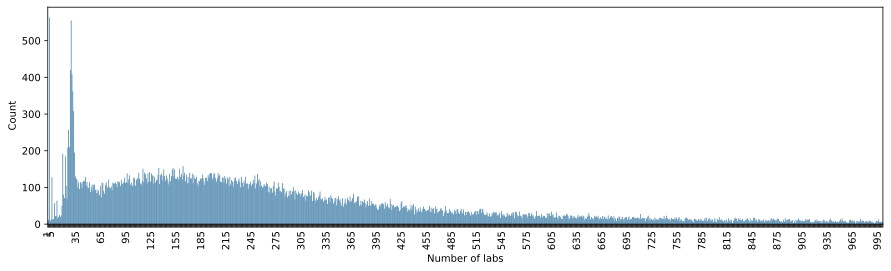

In [ ]:
plt.figure(figsize=(15,4))
g = sns.barplot(
    x=hist_df.n_labs, y=hist_df.cnt, color=sns.color_palette()[0])
for i, label in enumerate(g.get_xticklabels()):
  if i % 30 != 4 and i != 0:
    label.set_visible(False)
plt.xticks(rotation=90)  
plt.xlabel('Number of labs')
plt.ylabel('Count')  
plt.xlim(0,1000)

Zoom in

(0.0, 650.0)

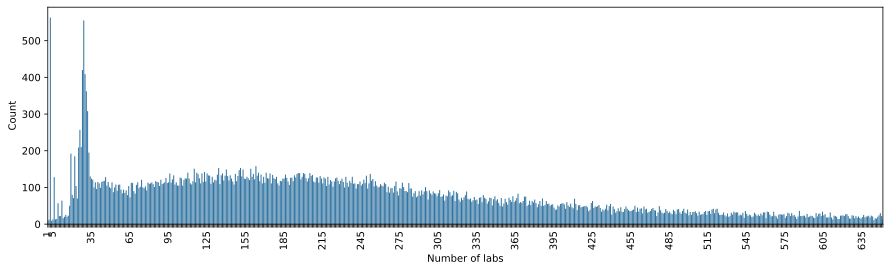

In [ ]:
plt.figure(figsize=(15,4))
g = sns.barplot(
    x=hist_df.n_labs, y=hist_df.cnt, color=sns.color_palette()[0])
for i, label in enumerate(g.get_xticklabels()):
  if i % 30 != 4 and i != 0:
    label.set_visible(False)
plt.xticks(rotation=90)  
plt.xlabel('Number of labs')
plt.ylabel('Count')  
plt.xlim(0,650)

The mathematical explanation of this is called central limit theorem. While this is by no means a deal breaker, the thins tails we see in the distribution can be a challenge for linear-regression models. This is because the extreme points tend to affect the likelihood the most, so having fewer of them makes your model more sensitive to outliers. Regularization can help with this, but if it becomes too much of a problem we can consider a different type of model (such as support-vector machines, or robust regression) instead of generalized linear regression.

In [ ]:
%%bigquery
# BigQuery ML create model statement:
CREATE OR REPLACE MODEL `{ml_table_prefix}mortality_models_according_labs_events`

OPTIONS(
  # Use logistic_reg for discrete predictions (classification) and linear_reg
  # for continuous predictions (forecasting).
  model_type = 'logistic_reg',
  # See the below aside (𝜎 = 0.5 ⇒ 𝜆 = 2)
  l2_reg = 2,
  # Identify the column to use as the label (dependent variable)
  input_label_cols = ["died"]
)
AS
# standard SQL query to train the model with:
SELECT
  COUNT(*) AS event_labs,
  MAX(HOSPITAL_EXPIRE_FLAG) as died
FROM
  `{admissions_table}`
  INNER JOIN `{labs_event}`
  USING (HADM_ID)
GROUP BY HADM_ID

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery scatter_df
SELECT
  COUNT(*) AS event_labs,
  MAX(HOSPITAL_EXPIRE_FLAG) as died
FROM
  `{admissions_table}`
  INNER JOIN `{labs_event}`
  USING (HADM_ID)  
GROUP BY HADM_ID

This is an example of the training table.

In [ ]:
scatter_df


event_labs  died
0             284     0
1             496     0
2            2049     0
3             400     0
4             128     0
...           ...   ...
58146          29     1
58147          24     1
58148          10     1
58149          12     1
58150          10     1

[58151 rows x 2 columns]

Its time to check model weights

In [ ]:
%%bigquery event_labs_model_weights
SELECT * FROM ML.WEIGHTS(MODEL `{ml_table_prefix}mortality_models_according_labs_events`)

In [ ]:
event_labs_model_weights

processed_input    weight category_weights
0      event_labs  0.000572               []
1   __INTERCEPT__ -2.392541               []

I see that *event_labs* has small weight and it is not enough to good predict

In [ ]:
params = {'max_prediction': hist_df.n_labs.max()}

In [ ]:
%%bigquery line_df --params $params
SELECT * FROM
ML.PREDICT(MODEL `{ml_table_prefix}complexity_mortality_models`, (
  SELECT * FROM
  UNNEST(GENERATE_ARRAY(1, @max_prediction)) AS event_labs
))

This is predict probabilities table. 

In [ ]:
line_df

predicted_died  ... event_labs
0                   0  ...          1
1                   0  ...          2
2                   0  ...          3
3                   0  ...          4
4                   0  ...          5
...               ...  ...        ...
13708               1  ...      13709
13709               1  ...      13710
13710               1  ...      13711
13711               1  ...      13712
13712               1  ...      13713

[13713 rows x 3 columns]

(0.0, 4000.0)

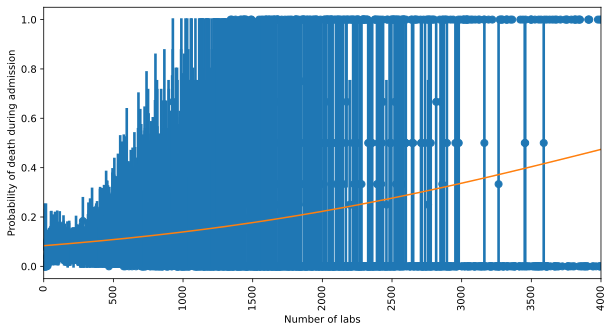

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(
    x='event_labs',
    y='died',
    data=scatter_df,
    fit_reg=False,
    x_bins=np.arange(1,
                     scatter_df.event_labs.max() + 1)
    )

plt.plot(line_df.event_labs,
         line_df.predicted_died_probs.apply(lambda x: x[0]['prob']))

plt.xlabel('Number of labs')
plt.ylabel('Probability of death during admission')
plt.xticks(rotation=90)    
plt.xlim(0,4000)

Zoom in

(0.0, 500.0)

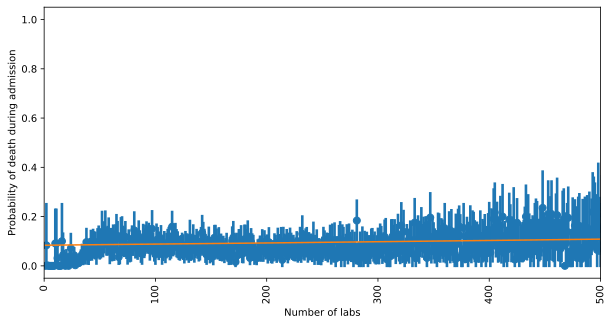

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(
    x='event_labs',
    y='died',
    data=scatter_df,
    fit_reg=False,
    x_bins=np.arange(1,
                     scatter_df.event_labs.max() + 1)
    )

plt.plot(line_df.event_labs,
         line_df.predicted_died_probs.apply(lambda x: x[0]['prob']))

plt.xlabel('Number of labs')
plt.ylabel('Probability of death during admission')
plt.xticks(rotation=90)    
plt.xlim(0,500)

Based on the graph, I believe that this model cannot provide us with good prediction accuracy. Therefore, I conclude that there is no relationship between the number of labs and the probability of death. Nevertheless, we will try to improve it

##**Classification model - 2 - by number of labs, gender, age, admission type, admission location, insurance, marital status, and ethnicity**

In [ ]:
%%bigquery DF_TOLEARNING
SELECT 
  IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200, DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS AGE,
  MARITAL_STATUS,
  GENDER,
  ADMISSION_TYPE,
  ADMISSION_LOCATION,
  INSURANCE,
  ETHNICITY,  
  num_labs as NUM_LABS,
  died
 
FROM
  (SELECT
    COUNT(*) AS num_labs,
    MAX(HOSPITAL_EXPIRE_FLAG) as died,
    ANY_VALUE(ADMITTIME) as ADMITTIME,
    ANY_VALUE(MARITAL_STATUS) as MARITAL_STATUS,
    ANY_VALUE(ADMISSION_TYPE) as ADMISSION_TYPE,	 	 
    ANY_VALUE(ADMISSION_LOCATION) as ADMISSION_LOCATION,
    ANY_VALUE(INSURANCE) as INSURANCE,
    ANY_VALUE(ETHNICITY) as ETHNICITY,
   SUBJECT_ID
  FROM
    `{admissions_table}` AS adm
    JOIN `{labs_event}` AS labs
  USING (HADM_ID, SUBJECT_ID)
  GROUP BY HADM_ID, SUBJECT_ID
  )
  JOIN `{patients_table}` AS patients
  USING (SUBJECT_ID)

Example table for train

In [ ]:
DF_TOLEARNING

AGE MARITAL_STATUS GENDER  ...               ETHNICITY NUM_LABS died
0      65.232033        MARRIED      F  ...  BLACK/AFRICAN AMERICAN      581    1
1      20.199863         SINGLE      M  ...      HISPANIC OR LATINO     2893    0
2      29.144422         SINGLE      F  ...   UNKNOWN/NOT SPECIFIED     4041    0
3      80.501027        MARRIED      M  ...                   WHITE     6873    1
4      66.272416        MARRIED      F  ...                   WHITE     1134    1
...          ...            ...    ...  ...                     ...      ...  ...
58146   0.172485           None      F  ...                   WHITE        2    0
58147   0.016427           None      F  ...                   WHITE        6    0
58148   0.005476           None      F  ...                   WHITE        3    0
58149   0.002738           None      F  ...   UNKNOWN/NOT SPECIFIED        9    0
58150   0.008214           None      F  ...                   WHITE        3    0

[58151 rows x 9 columns]

Time to train our model

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `{ml_table_prefix}complexity_feature_mortality`
OPTIONS(model_type='logistic_reg', l2_reg=2, input_label_cols=["died"])
AS
SELECT 
  IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200, DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS age,
  MARITAL_STATUS,
  GENDER,
  ADMISSION_TYPE,
  ADMISSION_LOCATION,
  INSURANCE,
  ETHNICITY,  
  num_labs,
  died
 
FROM
  (SELECT
    COUNT(*) AS num_labs,
    MAX(HOSPITAL_EXPIRE_FLAG) as died,
    ANY_VALUE(ADMITTIME) as ADMITTIME,
    ANY_VALUE(MARITAL_STATUS) as MARITAL_STATUS,
    ANY_VALUE(ADMISSION_TYPE) as ADMISSION_TYPE,	 	 
    ANY_VALUE(ADMISSION_LOCATION) as ADMISSION_LOCATION,
    ANY_VALUE(INSURANCE) as INSURANCE,
    ANY_VALUE(ETHNICITY) as ETHNICITY,
   SUBJECT_ID
  FROM
    `{admissions_table}` AS adm
    JOIN `{labs_event}` AS labs
  USING (HADM_ID, SUBJECT_ID)
  GROUP BY HADM_ID, SUBJECT_ID
  )
  JOIN `{patients_table}` AS patients
  USING (SUBJECT_ID)

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery weight_all
SELECT * FROM ML.WEIGHTS(MODEL `{ml_table_prefix}complexity_feature_mortality`)
ORDER BY weight DESC

Table with model weights

In [ ]:
weight_all

processed_input  ...                                   category_weights
0                 age  ...                                                 []
1            num_labs  ...                                                 []
2       __INTERCEPT__  ...                                                 []
3      MARITAL_STATUS  ...  [{'category': 'DIVORCED', 'weight': -0.3697188...
4              GENDER  ...  [{'category': 'M', 'weight': -0.35951872837762...
5      ADMISSION_TYPE  ...  [{'category': 'URGENT', 'weight': -0.228855164...
6  ADMISSION_LOCATION  ...  [{'category': 'EMERGENCY ROOM ADMIT', 'weight'...
7           INSURANCE  ...  [{'category': 'Government', 'weight': -0.55271...
8           ETHNICITY  ...  [{'category': 'NATIVE HAWAIIAN OR OTHER PACIFI...

[9 rows x 3 columns]

We see that *num_labs* still has a small weight. Age has bigger weight, but it seems to me that it is still not big enough. We open the weight in categorical variables

In [ ]:
title=weight_all['processed_input'][3:].to_list()
s=0
for i in weight_all['category_weights']:

  if len(i)>1:
    print(title[s])
    for x in i:
      print(x['category'],x['weight'])
  else:
    continue
  s+=1
  print("____________\n")    


MARITAL_STATUS
DIVORCED -0.36971886739184484
SINGLE -0.445495819534432
MARRIED -0.3304742025429302
UNKNOWN (DEFAULT) 0.08597386089763329
SEPARATED -0.3690825484020848
LIFE PARTNER -0.5261539327522753
WIDOWED -0.17327175054332558
_null_filler -0.3517818687084074
____________

GENDER
M -0.3595187283776261
F -0.31851181754370717
____________

ADMISSION_TYPE
URGENT -0.22885516490170754
NEWBORN -0.6871054040246538
ELECTIVE -0.71934737651752
EMERGENCY -0.21293061742995
____________

ADMISSION_LOCATION
EMERGENCY ROOM ADMIT -0.16722179783434138
TRANSFER FROM OTHER HEALT 0.39722388484428356
TRANSFER FROM SKILLED NUR 0.06209344808577427
HMO REFERRAL/SICK -0.4079910799703707
TRSF WITHIN THIS FACILITY -0.20629229712599448
PHYS REFERRAL/NORMAL DELI -0.6596018772416767
CLINIC REFERRAL/PREMATURE -0.3672665729480982
TRANSFER FROM HOSP/EXTRAM -0.225608350937147
** INFO NOT AVAILABLE ** -0.5647350063251118
____________

INSURANCE
Government -0.552715337942527
Medicaid -0.46657695207783545
Medicare -0.18

We see that the weights of the new variables are greater than the weight of the number of laboratory tests. This means that the new variables are more  influence on the accuracy of the predict.

In [ ]:
def set_precision(df):
  df['precision'] = df.true_positives / (df.true_positives + df.false_positives)

def plot_precision_recall(df, label=None):
  # manually add the threshold = -∞ point
  df = df[df.true_positives != 0]
  recall = [0] + list(df.recall)
  precision = [1] + list(df.precision)
  # x=recall, y=precision line chart
  plt.plot(recall, precision, label=label)  

In [ ]:
%%bigquery model1
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}mortality_models_according_labs_events`)

In [ ]:
%%bigquery model2
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}complexity_feature_mortality`)

In [ ]:
eval_queries = list()
for m in ['mortality_models_according_labs_events','complexity_feature_mortality']:
  eval_queries.append(
      'SELECT * FROM ML.EVALUATE('
      'MODEL `{ml_table_prefix}{m}`)'
      .format(m=m, **sub_dict))
eval_query = '\nUNION ALL\n'.join(eval_queries)
d=bq.query(eval_query).result().to_dataframe()
d.index=['models_according_labs_events','models_according_labs_events+features']
d

precision    recall  ...  log_loss   roc_auc
models_according_labs_events            0.333333  0.005831  ...  0.323940  0.651109
models_according_labs_events+features   0.611111  0.010000  ...  0.307957  0.742379

[2 rows x 6 columns]

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

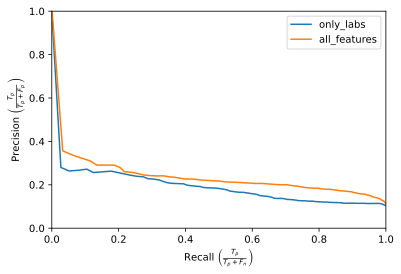

In [ ]:
set_precision(model1)
set_precision(model2)
plot_precision_recall(model1, label='only_labs')
plot_precision_recall(model2, label='all_features')
# plt.plot(
#     np.linspace(0, 1, 2), [comp_roc.precision.min()] * 2,
#     label='null model',
#     linestyle='--')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

From the ROC curves we see that adding the variables regarding a patient information and their admission improves the model.

Of course, neither of these models is very good when it comes to making predictions. For our last set of models, we'll try more earnestly to predict patient mortality.

##**Classification model - 3 - by number of labs, gender, age, admission type, admission location, insurance, marital status, and ethnicity and one hot encoding for 𝑚 most common labs**  
Where  𝑚∈ {8,16,32,64,128,256,512}

Firstly, make up the top lab events

In [ ]:
%%bigquery top_labs
SELECT ITEMID,COUNT,LABEL
FROM
(SELECT ITEMID,COUNT(*) AS COUNT
 FROM `{labs_event}`
 GROUP BY (ITEMID))
 JOIN `{labs_items}`
 USING(ITEMID)
 ORDER BY COUNT DESC

In [ ]:
top_labs

ITEMID   COUNT            LABEL
0     51221  881764       Hematocrit
1     50971  845737        Potassium
2     50983  808401           Sodium
3     50912  797389       Creatinine
4     50902  795480         Chloride
..      ...     ...              ...
721   51126       1    Promyelocytes
722   51055       1  Lipase, Pleural
723   51531       1        STDYURINE
724   51378       1   Metamyelocytes
725   51535       1             CD55

[726 rows x 3 columns]

Example table for train

In [ ]:
%%bigquery
WITH labs AS (
    SELECT
      HADM_ID,
      COUNT(*) AS COUNT_LABS,
      MAX(IF(ITEMID = 51221, 1.0, 0.0)) as `lab_51221`,
    MAX(IF(ITEMID = 50971, 1.0, 0.0)) as `lab_50971`,
    MAX(IF(ITEMID = 50983, 1.0, 0.0)) as `lab_50983`,
    MAX(IF(ITEMID = 50912, 1.0, 0.0)) as `lab_50912`,
    MAX(IF(ITEMID = 50902, 1.0, 0.0)) as `lab_50902`,
    MAX(IF(ITEMID = 51006, 1.0, 0.0)) as `lab_51006`,
    MAX(IF(ITEMID = 50882, 1.0, 0.0)) as `lab_50882`,
    MAX(IF(ITEMID = 51265, 1.0, 0.0)) as `lab_51265`,
    MAX(IF(ITEMID = 50868, 1.0, 0.0)) as `lab_50868`,
    MAX(IF(ITEMID = 51301, 1.0, 0.0)) as `lab_51301`,
    MAX(IF(ITEMID = 51222, 1.0, 0.0)) as `lab_51222`,
    MAX(IF(ITEMID = 50931, 1.0, 0.0)) as `lab_50931`,
    MAX(IF(ITEMID = 51249, 1.0, 0.0)) as `lab_51249`,
    MAX(IF(ITEMID = 51279, 1.0, 0.0)) as `lab_51279`,
    MAX(IF(ITEMID = 51248, 1.0, 0.0)) as `lab_51248`,
    MAX(IF(ITEMID = 51250, 1.0, 0.0)) as `lab_51250`
    FROM `physionet-data.mimiciii_clinical.labevents`
    GROUP BY HADM_ID
    )

    SELECT 
    * EXCEPT (SUBJECT_ID,HADM_ID,ITEMID,ADMITTIME,DOB),
    IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
       DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS age,
    FROM 
    (SELECT SUBJECT_ID,HADM_ID,ITEMID FROM `physionet-data.mimiciii_clinical.labevents`) 
    JOIN
    (SELECT SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY ,ADMITTIME,HOSPITAL_EXPIRE_FLAG AS died FROM `physionet-data.mimiciii_clinical.admissions`)
    USING (SUBJECT_ID,HADM_ID)
    JOIN
    (SELECT DOB,GENDER,SUBJECT_ID FROM`physionet-data.mimiciii_clinical.patients`)
    USING (SUBJECT_ID)
    JOIN labs
    USING (HADM_ID) 
    limit 100

ADMISSION_TYPE         ADMISSION_LOCATION  ... lab_51250        age
0       EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  76.522930
1       EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  47.843943
2       EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  41.787817
3       EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  50.146475
4       EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  32.766598
..            ...                        ...  ...       ...        ...
95      EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  64.835044
96      EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  83.619439
97      EMERGENCY       EMERGENCY ROOM ADMIT  ...       1.0  55.310062
98      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...       1.0  79.452430
99        NEWBORN  CLINIC REFERRAL/PREMATURE  ...       1.0   0.000000

[100 rows x 25 columns]

Time to train model

This time around we're using l1_reg instead of l2_reg because we expect that some of our some of our many variables will not significantly impact the outcome, and we would prefer a sparse model if possible.

In [ ]:
top_m_labs = (8, 16, 32, 64, 128, 256, 512)
query_jobs = list()
for m in top_m_labs:
  labs_columns = list()
  for _, row in top_labs.iloc[:m].iterrows():
    labs_columns.append('MAX(IF(ITEMID = {0}, 1.0, 0.0))'
                             ' as `lab_{0}`'.format(row.ITEMID))
  query = """
    CREATE OR REPLACE MODEL `{ml_table_prefix}mortality_feature_top_labs_{m}`
  OPTIONS(model_type='logistic_reg', l1_reg=2, input_label_cols=["died"])
  AS
    WITH labs AS (
    SELECT
      HADM_ID,
      COUNT(*) AS COUNT_LABS,
      {labs_columns}
    FROM `{labs_event}`
    GROUP BY HADM_ID
    )

    SELECT 
    * EXCEPT (SUBJECT_ID,HADM_ID,ITEMID,ADMITTIME,DOB),
    IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
       DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS age,
    FROM 
    (SELECT SUBJECT_ID,HADM_ID,ITEMID FROM `{labs_event}`) 
    JOIN
    (SELECT SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY ,ADMITTIME,HOSPITAL_EXPIRE_FLAG AS died FROM `{admissions_table}`)
    USING (SUBJECT_ID,HADM_ID)
    JOIN
    (SELECT DOB,GENDER,SUBJECT_ID FROM`{patients_table}`)
    USING (SUBJECT_ID)
    JOIN labs
    USING (HADM_ID)
  """.format(m=m,labs_columns=',\n    '.join(labs_columns),**sub_dict)
  query_jobs.append(bq.query(query))
for j in query_jobs:
  j.exception()

Time to plot ROC curve

In [ ]:
eval_queries = list()
for m in top_m_labs:
  eval_queries.append(
      'SELECT * FROM ML.EVALUATE('
      'MODEL `{ml_table_prefix}mortality_feature_top_labs_{}`)'
      .format(m, **sub_dict))
eval_query = '\nUNION ALL\n'.join(eval_queries)
bq.query(eval_query).result().to_dataframe()

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.476190  0.023697  0.832209  0.045147  0.416909  0.709716
1   0.538462  0.029167  0.834684  0.055336  0.415616  0.706230
2   0.503876  0.038622  0.830921  0.071744  0.406525  0.729181
3   0.875000  0.004217  0.831808  0.008393  0.394901  0.760225
4   0.766423  0.060624  0.833099  0.112360  0.375335  0.809382
5   0.661224  0.285546  0.854879  0.398851  0.345021  0.832355
6   0.729792  0.182659  0.848551  0.292187  0.359443  0.825181

Plotting ROC and precision-recall curves

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

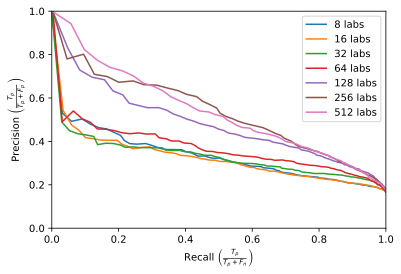

In [ ]:
for m in top_m_labs:
  df = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}mortality_feature_top_labs_{}`)'
                .format(m, **sub_dict)).result().to_dataframe()
  set_precision(df)
  plot_precision_recall(df, label='{} labs'.format(m))

# plt.plot(
#     np.linspace(0, 1, 2), [df.precision.min()] * 2,
#     label='null model',
#     linestyle='--')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

The model with m = 512 seems to be overfitting the data, while somewhere between m = 128 and m = 256 seems to be the sweet spot for model flexibility.

Actually, the predictive power of our model¹ isn't nearly as interesting as it's weights and what they tell us. In the next section, we'll dig into them.



Let's have a look at the weights from the m = 128 model.

In [ ]:
%%bigquery weights_128
SELECT * FROM ML.WEIGHTS(MODEL `{ml_table_prefix}mortality_feature_top_labs_128`)
ORDER BY weight DESC

In [ ]:
weights_128

processed_input  ...                                   category_weights
0             lab_51257  ...                                                 []
1             lab_50909  ...                                                 []
2             lab_51218  ...                                                 []
3             lab_50908  ...                                                 []
4             lab_50825  ...                                                 []
..                  ...  ...                                                ...
132  ADMISSION_LOCATION  ...  [{'category': 'PHYS REFERRAL/NORMAL DELI', 'we...
133           INSURANCE  ...  [{'category': 'Private', 'weight': -0.33721908...
134      MARITAL_STATUS  ...  [{'category': '_null_filler', 'weight': -0.135...
135           ETHNICITY  ...  [{'category': 'HISPANIC/LATINO - HONDURAN', 'w...
136              GENDER  ...  [{'category': 'M', 'weight': -0.26831609486153...

[137 rows x 3 columns]

First we'll look at the weights for the numerical inputs.

In [ ]:
pd.options.display.max_rows=500
weights_128['ITEMID'] = weights_128.processed_input \
  .apply(lambda x: int(x.split('_')[1]) if x.startswith('lab_') else x)
weights_128  
view_df = weights_128.merge(top_labs,how='left', on='ITEMID') 
view_df = view_df[~pd.isnull(view_df.weight)]
view_df[['processed_input', 'LABEL', 'weight', 'COUNT']]

processed_input                            LABEL    weight     COUNT
0         lab_51257              Nucleated Red Cells  0.255663   16568.0
1         lab_50909                         Cortisol  0.206321   13554.0
2         lab_51218                Granulocyte Count  0.204007   24375.0
3         lab_50908                      CK-MB Index  0.154342   22911.0
4         lab_50825                      Temperature  0.145432  129444.0
5         lab_50801       Alveolar-arterial Gradient  0.143498   22016.0
6         lab_50819                             PEEP  0.142498   86911.0
7         lab_50823                      Required O2  0.141914   22057.0
8         lab_50813                          Lactate  0.137076  187116.0
9         lab_51214           Fibrinogen, Functional  0.134105   45935.0
10        lab_50826                     Tidal Volume  0.118476   83805.0
11        lab_51104             Urea Nitrogen, Urine  0.115136   13294.0
12        lab_51275                              PTT  0.110955  474930.0
13        lab_50802                      Base Excess  0.110690  490651.0
14        lab_51237                          INR(PT)  0.110259  471176.0
15        lab_51274                               PT  0.110242  469083.0
16        lab_50804             Calculated Total CO2  0.110219  490641.0
17        lab_50818                             pCO2  0.109548  490594.0
18        lab_50821                              pO2  0.109307  490628.0
19        lab_50820                               pH  0.104140  530752.0
20        lab_51007                        Uric Acid  0.099312   18355.0
21        lab_50816                           Oxygen  0.099268  127960.0
22        lab_50883                Bilirubin, Direct  0.095494   45205.0
23        lab_50817                Oxygen Saturation  0.092758  173418.0
24        lab_50954       Lactate Dehydrogenase (LD)  0.091158  107120.0
25        lab_51482                    Hyaline Casts  0.090868   15118.0
26        lab_50931                          Glucose  0.090173  748896.0
27        lab_51093                Osmolality, Urine  0.088802   18838.0
28        lab_50912                       Creatinine  0.088614  797389.0
29        lab_51006                    Urea Nitrogen  0.087416  791838.0
30        lab_50884              Bilirubin, Indirect  0.086861   44385.0
31        lab_50935                      Haptoglobin  0.086001   11970.0
32        lab_50808                     Free Calcium  0.085903  249110.0
33        lab_51082                Creatinine, Urine  0.083197   33062.0
34        lab_50910             Creatine Kinase (CK)  0.083075  132400.0
35        lab_51144                            Bands  0.078841   75587.0
36        lab_50911    Creatine Kinase, MB Isoenzyme  0.078059  115802.0
37        lab_51003                       Troponin T  0.077059   87238.0
38        lab_50862                          Albumin  0.075894  146694.0
39        lab_51143             Atypical Lymphocytes  0.074792   59334.0
40        lab_51100                    Sodium, Urine  0.073687   25990.0
41        lab_51251                   Metamyelocytes  0.073105   59206.0
42        lab_51255                       Myelocytes  0.072468   59158.0
43        lab_51009                       Vancomycin  0.071942   54728.0
44        lab_51260                       Ovalocytes  0.067751   16180.0
45        lab_50967                        Phenytoin  0.066094   22453.0
46        lab_50878  Asparate Aminotransferase (AST)  0.054382  219452.0
47        lab_50861   Alanine Aminotransferase (ALT)  0.053886  219462.0
48        lab_50964             Osmolality, Measured  0.050698   18816.0
49        lab_50956                           Lipase  0.042474   65373.0
50        lab_50885                 Bilirubin, Total  0.039935  238263.0
51        lab_50827                 Ventilation Rate  0.038212   77611.0
52        lab_51266                   Platelet Smear  0.037483   44151.0
53        lab_50863             Alkaline Phosphatase  0.035616

We see have a list of lab events, sorted from most fatal to least fatal according to our model.

Going back to our original question, we can see that the weight for *COUNT_LABS*	(a.k.a the number of lab events) has essentially gone to zero (0.000007). The average lab events weight is also very small:


In [ ]:
view_df[~pd.isnull(view_df.LABEL)].weight.mean()

0.014106780876409816

So we can conclude that given that a patient has been admitted to the ICU, the number of lab events they've been given does not predict their outcome beyond the linear effect of the component diagnoses.

Let's try to improve our model by adding a diagnosis

##**Classification model - 4 - by number of labs, gender, age, admission type, admission location, insurance, marital status, and ethnicity and one hot encoding for the most common 128 lab events and the most common 256 diagnoses**  
Where  𝑚∈ {8,16,32,64,128,256,512}

Top 256 diagnoses

In [ ]:
%%bigquery top_diagnoses
WITH top_diag AS (
  SELECT COUNT(*) AS count, ICD9_CODE FROM `{diagnoses_icd_table}`
  GROUP BY ICD9_CODE
)
SELECT top_diag.ICD9_CODE, icd_lookup.SHORT_TITLE, top_diag.count FROM
top_diag JOIN
 `{d_icd_diagnoses_table}` AS icd_lookup
USING (ICD9_CODE)
ORDER BY count DESC 

In [ ]:
top_diagnoses.head()

ICD9_CODE               SHORT_TITLE  count
0      4019          Hypertension NOS  20703
1      4280                   CHF NOS  13111
2     42731       Atrial fibrillation  12891
3     41401  Crnry athrscl natve vssl  12429
4      5849  Acute kidney failure NOS   9119

To compile example table for train take a lot of time

In [ ]:
# top_m_labs = 128
# query_jobs = list()
# top_n_diagnoses = 256
# diagnosis_columns = list()
# labs_columns = list()
# for _, row in top_labs.iloc[:top_m_labs].iterrows():
#   labs_columns.append('MAX(IF(ITEMID = {0}, 1.0, 0.0))'
#                              ' as `lab_{0}`'.format(row.ITEMID))
# for _, row in top_diagnoses.iloc[:top_n_diagnoses].iterrows():
#   diagnosis_columns.append('MAX(IF(ICD9_CODE = "{0}", 1.0, 0.0))'
#                              ' as `icd9_{0}`'.format(row.ICD9_CODE))  
#   query = """
#         WITH labs AS (
#     SELECT
#       HADM_ID,
#       COUNT(*) AS COUNT_LABS,
#       {labs_columns}
#     FROM `{labs_event}`
#     GROUP BY HADM_ID
#     )
#     SELECT * EXCEPT (HADM_ID) FROM
#     (SELECT 
#     * EXCEPT (SUBJECT_ID,ITEMID,ADMITTIME,DOB),
#     IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
#        DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS age,
#     FROM 
#     (SELECT SUBJECT_ID,HADM_ID,ITEMID FROM `{labs_event}`) 
#     JOIN
#     (SELECT SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY ,ADMITTIME,HOSPITAL_EXPIRE_FLAG AS died FROM `{admissions_table}`)
#     USING (SUBJECT_ID,HADM_ID)
#     JOIN
#     (SELECT DOB,GENDER,SUBJECT_ID FROM`{patients_table}`)
#     USING (SUBJECT_ID)
#     JOIN labs
#     USING (HADM_ID)
#     )
#     JOIN
#     (SELECT
#       HADM_ID,
#       COUNT(*) AS num_diag,
#       {diag_cols}
#     FROM `{diagnoses_icd_table}`
#     WHERE ICD9_CODE IS NOT NULL
#     GROUP BY HADM_ID)
#     USING (HADM_ID)
#   """.format(m=m,labs_columns=',\n    '.join(labs_columns),diag_cols=',\n    '.join(diagnosis_columns),**sub_dict)
# ex.result().to_dataframe().head()

Lets go right to train model

In [ ]:
top_m_labs = 128
query_jobs = list()
top_n_diagnoses = 256
diagnosis_columns = list()
labs_columns = list()
for _, row in top_labs.iloc[:top_m_labs].iterrows():
  labs_columns.append('MAX(IF(ITEMID = {0}, 1.0, 0.0))'
                             ' as `lab_{0}`'.format(row.ITEMID))
for _, row in top_diagnoses.iloc[:top_n_diagnoses].iterrows():
  diagnosis_columns.append('MAX(IF(ICD9_CODE = "{0}", 1.0, 0.0))'
                             ' as `icd9_{0}`'.format(row.ICD9_CODE))  
  query = """
  CREATE OR REPLACE MODEL `{ml_table_prefix}predict_mortality_diag_labs`
  OPTIONS(model_type='logistic_reg', l1_reg=2, input_label_cols=["died"])
  AS
        WITH labs AS (
    SELECT
      HADM_ID,
      COUNT(*) AS COUNT_LABS,
      {labs_columns}
    FROM `{labs_event}`
    GROUP BY HADM_ID
    )
    SELECT * EXCEPT (HADM_ID) FROM
    (SELECT 
    * EXCEPT (SUBJECT_ID,ITEMID,ADMITTIME,DOB),
    IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
       DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS age,
    FROM 
    (SELECT SUBJECT_ID,HADM_ID,ITEMID FROM `{labs_event}`) 
    JOIN
    (SELECT SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY ,ADMITTIME,HOSPITAL_EXPIRE_FLAG AS died FROM `{admissions_table}`)
    USING (SUBJECT_ID,HADM_ID)
    JOIN
    (SELECT DOB,GENDER,SUBJECT_ID FROM`{patients_table}`)
    USING (SUBJECT_ID)
    JOIN labs
    USING (HADM_ID)
    )
    JOIN
    (SELECT
      HADM_ID,
      COUNT(*) AS num_diag,
      {diag_cols}
    FROM `{diagnoses_icd_table}`
    WHERE ICD9_CODE IS NOT NULL
    GROUP BY HADM_ID)
    USING (HADM_ID)
  """.format(labs_columns=',\n    '.join(labs_columns),diag_cols=',\n    '.join(diagnosis_columns),**sub_dict)
query_jobs.append(bq.query(query))

for j in query_jobs:
  j.exception()

Evaluation

In [ ]:
eval_queries = list()
eval_queries.append(
      'SELECT * FROM ML.EVALUATE('
      'MODEL `{ml_table_prefix}predict_mortality_diag_labs`)'
      .format( **sub_dict))
eval_query = '\nUNION ALL\n'.join(eval_queries)
bq.query(eval_query).result().to_dataframe()

precision    recall  accuracy  f1_score  log_loss   roc_auc
0        0.7  0.323674  0.867588  0.442664  0.306609  0.880394

Plot precision recall curve to compare model with *128 Top Lab events+256 Top Diagnoses* to model with *128 Top Lab events*

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

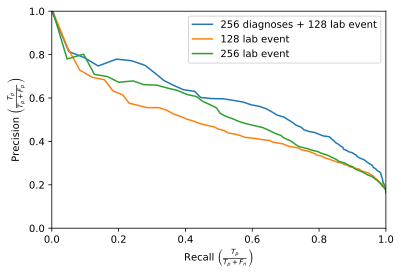

In [ ]:
df1 = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_diag_labs`)'
                .format(**sub_dict)).result().to_dataframe()

df2 = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}mortality_feature_top_labs_128`)'
                .format(m, **sub_dict)).result().to_dataframe()

df3 = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}mortality_feature_top_labs_256`)'
                .format(m, **sub_dict)).result().to_dataframe()                

set_precision(df1)
plot_precision_recall(df1, label='256 diagnoses + 128 lab event')

set_precision(df2)
plot_precision_recall(df2, label='128 lab event')

set_precision(df3)
plot_precision_recall(df3, label='256 lab event')

# plt.plot(
#     np.linspace(0, 1, 2), [df2.precision.min()] * 2,
#     label='null model',
#     linestyle='--')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

As we can see from the graph, adding the top 256 diagnoses actually improves our model.

Lets look on model weights

In [ ]:
%%bigquery weights_128_256
SELECT * FROM ML.WEIGHTS(MODEL `{ml_table_prefix}predict_mortality_diag_labs`)
ORDER BY weight DESC

In [ ]:
weights_128_256.head()

processed_input    weight category_weights
0       icd9_V667  1.648685               []
1      icd9_V4986  0.918412               []
2       icd9_4275  0.727264               []
3       icd9_3484  0.592067               []
4       icd9_1977  0.501159               []

First we'll look at the weights for the numerical inputs.

In [ ]:
weights_128_256['ITEMID'] = weights_128_256.processed_input \
  .apply(lambda x: x[len('icd9_'):] if x.startswith('icd9_') else x)  
weights_128_256['ITEMID'] = weights_128_256.ITEMID \
  .apply(lambda x: int(x.split('_')[1]) if x.startswith('lab_') else x)
top_diagnoses1=top_diagnoses.rename(columns={'ICD9_CODE': 'ITEMID','SHORT_TITLE':'LABEL','count':'COUNT'})
dff=pd.concat([top_labs,top_diagnoses1])
view_df = weights_128_256.merge(dff,how='left', on='ITEMID')
view_df = view_df[~pd.isnull(view_df.weight)]
view_df[['processed_input', 'LABEL', 'weight', 'COUNT']]

processed_input                            LABEL    weight     COUNT
0         icd9_V667         Encountr palliative care  1.648685    1020.0
1        icd9_V4986         Do not resusctate status  0.918412    1327.0
2         icd9_4275                   Cardiac arrest  0.727264    1361.0
3         icd9_3484             Compression of brain  0.592067     711.0
4         icd9_1977           Second malig neo liver  0.501159     794.0
5          icd9_515         Postinflam pulm fibrosis  0.458844     544.0
6          icd9_570          Acute necrosis of liver  0.431819    1067.0
7        icd9_51884         Acute & chronc resp fail  0.426374     684.0
8         icd9_5570         Ac vasc insuff intestine  0.389654     497.0
9          icd9_431         Intracerebral hemorrhage  0.377781    1367.0
10       icd9_V1011         Hx-bronchogenic malignan  0.375203     519.0
11       icd9_78551                Cardiogenic shock  0.370806    1154.0
12       icd9_42741         Ventricular fibrillation  0.352752     568.0
13        icd9_1970         Secondary malig neo lung  0.325720     754.0
14        icd9_1983          Sec mal neo brain/spine  0.320006     767.0
15        icd9_5781                   Blood in stool  0.309218     690.0
16       icd9_78559             Shock w/o trauma NEC  0.307463     535.0
17        icd9_0389                   Septicemia NOS  0.302748    3725.0
18       icd9_99592                    Severe sepsis  0.296168    3912.0
19        icd9_5789          Gastrointest hemorr NOS  0.295692    1397.0
20       icd9_43491         Crbl art ocl NOS w infrc  0.274524     731.0
21        lab_51218                Granulocyte Count  0.268938   24375.0
22        lab_51257              Nucleated Red Cells  0.260585   16568.0
23       icd9_78959                      Ascites NEC  0.251548     978.0
24        icd9_1985         Secondary malig neo bone  0.250302     843.0
25       icd9_78552                     Septic shock  0.244396    2586.0
26        icd9_5712          Alcohol cirrhosis liver  0.233369    1202.0
27        icd9_5722           Hepatic encephalopathy  0.231921     666.0
28       icd9_E8889                         Fall NOS  0.225236     997.0
29       icd9_51881         Acute respiratry failure  0.218681    7497.0
30        icd9_9982         Accidental op laceration  0.212922     929.0
31       icd9_29410          Dementia w/o behav dist  0.211653     613.0
32        icd9_2762                         Acidosis  0.202823    4528.0
33         icd9_430          Subarachnoid hemorrhage  0.201034     658.0
34       icd9_E9331           Adv eff antineoplastic  0.199364     559.0
35        icd9_5723              Portal hypertension  0.191338    1007.0
36        icd9_2869          Coagulat defect NEC/NOS  0.189693    1016.0
37       icd9_43411             Crbl emblsm w infrct  0.187838     642.0
38        icd9_2867          Acq coagul factor defic  0.184710     466.0
39       icd9_03811         Meth susc Staph aur sept  0.183943     515.0
40       icd9_34830               Encephalopathy NOS  0.179766     674.0
41        icd9_5715           Cirrhosis of liver NOS  0.176079    1287.0
42        icd9_V103          Hx of breast malignancy  0.174465    1277.0
43        icd9_5845         Ac kidny fail, tubr necr  0.170546    2287.0
44        icd9_4928                    Emphysema NEC  0.161913     641.0
45        icd9_3485                   Cerebral edema  0.161549     978.0
46        lab_50909                         Cortisol  0.157406   13554.0
47        icd9_V440              Tracheostomy status  0.152329     580.0
48        icd9_V707               Exam-clincal trial  0.147432     530.0
49        lab_50801       Alveolar-arterial Gradient  0.146081   22016.0
50        lab_50823                      Required O2  0.144661   22057.0
51        icd9_5849         Acute kidney failure NOS  0.142057    9119.0
52       icd9_03842                E coli septicemia  0.139614     467.0
53        lab_50908                      CK-MB Index  0.138029

We see have a list of diagnoses and lab events, sorted from most fatal to least fatal according to our model.

Going back to our original question, we can see that the weight for num_diag (a.k.a the number of diagnoses) has essentially gone to zero (0.002395) as well as the weight for COUNT_LABS (a.k.a the number of lab events) is very small (-0.000011). The average diagnoses weight and lab event is also very small:

In [ ]:
view_df[~pd.isnull(view_df.LABEL)].weight.mean()

0.010698212781014632

Nonetheless, the graph shows that the first 20 lines are occupied by diagnoses, namely they have more weight. So we can conclude that diagnoses provide a better prediction than a lab event

Social determinant weights

In [ ]:
df_new=weights_128_256[pd.isnull(weights_128_256['weight'])]
title=weights_128_256[pd.isnull(weights_128_256['weight'])]['processed_input'].to_list()
s=0
for i in df_new['category_weights']:
  print(title[s])
  for x in i:
    print(x['category'],x['weight'])
  s+=1
  print("____________\n")  

ADMISSION_TYPE
NEWBORN -0.36810775387185873
ELECTIVE -0.40683197692928613
URGENT -0.33409536662646383
EMERGENCY -0.2701287519528017
____________

ADMISSION_LOCATION
HMO REFERRAL/SICK -0.10259030931933484
EMERGENCY ROOM ADMIT -0.2643567527009267
PHYS REFERRAL/NORMAL DELI -0.3435315099790993
TRSF WITHIN THIS FACILITY -0.34590625812923276
CLINIC REFERRAL/PREMATURE -0.3012130931299697
TRANSFER FROM SKILLED NUR -0.10978820484464917
TRANSFER FROM HOSP/EXTRAM -0.30747637706902115
TRANSFER FROM OTHER HEALT 0.25916254990615106
** INFO NOT AVAILABLE ** -0.32087245589246244
____________

INSURANCE
Medicare -0.22028550766516702
Private -0.3752668741003606
Self Pay -0.012848172094661934
Government -0.4056960954394789
Medicaid -0.401392460905443
____________

MARITAL_STATUS
SEPARATED -0.3793807062856737
DIVORCED -0.37973753232901925
WIDOWED -0.2063564938829422
LIFE PARTNER -0.7430609709474453
UNKNOWN (DEFAULT) -0.2669391115576381
MARRIED -0.28344501638624664
_null_filler -0.09398459312517879
SINGLE 

##**Bonus: Classification model - 5 - by number of labs, gender, age, admission type, admission location, insurance, marital status, and ethnicity  but limit the data that was collected in the first 24 hours of admission**

This time we will make a prediction based on the lab events done in the first 24 hours of admission

Example table for train

In [ ]:
%%bigquery
WITH summary AS (
SELECT * FROM
(SELECT SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,
MARITAL_STATUS,ETHNICITY,GENDER,HOSPITAL_EXPIRE_FLAG as dead,
IF(DATETIME_DIFF(CHARTTIME, ADMITTIME, HOUR)<= 24,
       1, 0) AS TIME,
IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
       DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS AGE,       
FROM
( 
`{admissions_table}` JOIN 
`{labs_event}`
USING (HADM_ID,SUBJECT_ID)
JOIN
`{patients_table}`
USING (SUBJECT_ID)))
WHERE TIME=1)

SELECT *EXCEPT(HADM_ID,SUBJECT_ID,TIME) FROM
summary
JOIN
(SELECT count(*) as Num_labs,HADM_ID
From summary
GROUP BY HADM_ID)
USING (HADM_ID)
LIMIT 50



ADMISSION_TYPE         ADMISSION_LOCATION  ...        AGE Num_labs
0       EMERGENCY       EMERGENCY ROOM ADMIT  ...  41.787817      154
1        ELECTIVE  PHYS REFERRAL/NORMAL DELI  ...  45.511294      104
2          URGENT  TRANSFER FROM HOSP/EXTRAM  ...  65.538672       51
3       EMERGENCY       EMERGENCY ROOM ADMIT  ...  68.958248      171
4        ELECTIVE  PHYS REFERRAL/NORMAL DELI  ...  63.134839      430
5       EMERGENCY       EMERGENCY ROOM ADMIT  ...  74.119097      183
6       EMERGENCY       EMERGENCY ROOM ADMIT  ...  51.745380      220
7       EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  52.208077      129
8       EMERGENCY       EMERGENCY ROOM ADMIT  ...  64.019165      116
9       EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  74.959617      101
10      EMERGENCY       EMERGENCY ROOM ADMIT  ...  50.847365      202
11      EMERGENCY       EMERGENCY ROOM ADMIT  ...  55.449692      155
12       ELECTIVE  PHYS REFERRAL/NORMAL DELI  ...  75.994524      198
13      EMERGENCY       EMERGENCY ROOM ADMIT  ...  19.293634      278
14      EMERGENCY  CLINIC REFERRAL/PREMATURE  ...  60.657084       98
15      EMERGENCY  CLINIC REFERRAL/PREMATURE  ...  48.793977       68
16      EMERGENCY  CLINIC REFERRAL/PREMATURE  ...  49.694730      186
17       ELECTIVE  PHYS REFERRAL/NORMAL DELI  ...  76.722793      149
18       ELECTIVE  PHYS REFERRAL/NORMAL DELI  ...  73.133470      219
19      EMERGENCY       EMERGENCY ROOM ADMIT  ...  41.486653       61
20      EMERGENCY       EMERGENCY ROOM ADMIT  ...  73.492129       63
21      EMERGENCY       EMERGENCY ROOM ADMIT  ...  83.383984      159
22         URGENT  TRANSFER FROM HOSP/EXTRAM  ...  82.146475      106
23       ELECTIVE  PHYS REFERRAL/NORMAL DELI  ...  68.205339       87
24      EMERGENCY       EMERGENCY ROOM ADMIT  ...  72.750171      175
25       ELECTIVE  PHYS REFERRAL/NORMAL DELI  ...  59.364819      161
26      EMERGENCY       EMERGENCY ROOM ADMIT  ...  75.060917      123
27      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  71.997262      146
28      EMERGENCY       EMERGENCY ROOM ADMIT  ...  63.767283      192
29      EMERGENCY       EMERGENCY ROOM ADMIT  ...  45.204654      219
30      EMERGENCY  CLINIC REFERRAL/PREMATURE  ...  56.555784       86
31      EMERGENCY       EMERGENCY ROOM ADMIT  ...  85.199179      250
32      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  39.307324       94
33      EMERGENCY       EMERGENCY ROOM ADMIT  ...  57.344285       97
34      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  39.307324       94
35      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  39.307324       94
36      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  60.870637      334
37      EMERGENCY       EMERGENCY ROOM ADMIT  ...  95.000000      164
38      EMERGENCY  TRANSFER FROM OTHER HEALT  ...  76.602327      246
39      EMERGENCY       EMERGENCY ROOM ADMIT  ...  67.734428      127
40      EMERGENCY       EMERGENCY ROOM ADMIT  ...  57.645448      132
41      EMERGENCY  PHYS REFERRAL/NORMAL DELI  ...  60.878850      325
42        NEWBORN  PHYS REFERRAL/NORMAL DELI  ...   0.000000       82
43      EMERGENCY       EMERGENCY ROOM ADMIT  ...  42.464066      439
44      EMERGENCY       EMERGENCY ROOM ADMIT  ...  49.845311      106
45      EMERGENCY       EMERGENCY ROOM ADMIT  ...  19.989049      118
46      EMERGENCY       EMERGENCY ROOM ADMIT  ...  86.628337      206
47      EMERGENCY       EMERGENCY ROOM ADMIT  ...  65.207392      119
48      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  ...  71.556468      212
49      EMERGENCY       EMERGENCY ROOM ADMIT  ...  77.470226       89

[50 rows x 9 columns]

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `{ml_table_prefix}mortality_24_hours`

OPTIONS(
  model_type = 'logistic_reg',
  # See the below aside (𝜎 = 0.5 ⇒ 𝜆 = 2)
  l2_reg = 2,
  input_label_cols = ["died"]
)
AS
# standard SQL query to train the model with:
WITH summary AS (
SELECT * FROM
( 
  SELECT SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,
MARITAL_STATUS,ETHNICITY,GENDER,HOSPITAL_EXPIRE_FLAG as died,
IF(DATETIME_DIFF(CHARTTIME, ADMITTIME, HOUR)<= 24,
       1, 0) AS TIME,
IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
       DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS AGE,       
FROM
( 
`{admissions_table}` JOIN 
`{labs_event}`
USING (HADM_ID,SUBJECT_ID)
JOIN
`{patients_table}`
USING (SUBJECT_ID))
)
WHERE TIME=1)

SELECT *EXCEPT(HADM_ID,SUBJECT_ID,TIME) FROM
summary
JOIN
(SELECT count(*) as Num_labs,HADM_ID
From summary
GROUP BY HADM_ID)
USING (HADM_ID)

Empty DataFrame
Columns: []
Index: []

In [ ]:
eval_queries = list()
eval_queries.append(
      'SELECT * FROM ML.EVALUATE('
      'MODEL `{ml_table_prefix}mortality_24_hours`)'
      .format( **sub_dict))
eval_query = '\nUNION ALL\n'.join(eval_queries)
bq.query(eval_query).result().to_dataframe()

precision    recall  accuracy  f1_score  log_loss  roc_auc
0   0.659091  0.044073  0.872702  0.082621  0.339861  0.74688

In [ ]:
%%bigquery weights_24
SELECT * FROM ML.WEIGHTS(MODEL `{ml_table_prefix}mortality_24_hours`)
ORDER BY weight DESC

In [ ]:
weights_24

processed_input  ...                                   category_weights
0                 AGE  ...                                                 []
1            Num_labs  ...                                                 []
2       __INTERCEPT__  ...                                                 []
3      ADMISSION_TYPE  ...  [{'category': 'EMERGENCY', 'weight': -0.199193...
4  ADMISSION_LOCATION  ...  [{'category': 'HMO REFERRAL/SICK', 'weight': 0...
5           INSURANCE  ...  [{'category': 'Medicaid', 'weight': -0.5151097...
6      MARITAL_STATUS  ...  [{'category': 'SINGLE', 'weight': -0.510721995...
7           ETHNICITY  ...  [{'category': 'HISPANIC/LATINO - SALVADORAN', ...
8              GENDER  ...  [{'category': 'F', 'weight': -0.33209721014908...

[9 rows x 3 columns]

We see that the Num_labs weight really increased from 0.000508 to 0.006802.But how much will this affect on predictive power?

Text(0, 0.5, 'Precision $\\left(\\frac{T_p}{T_p + F_p} \\right)$')

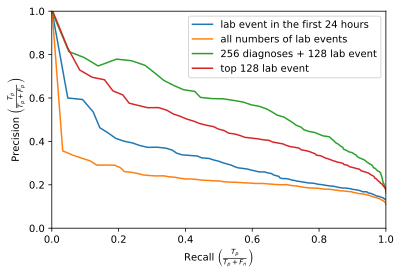

In [ ]:
df1 = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}mortality_24_hours`)'
                .format(**sub_dict)).result().to_dataframe()

df2 = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}complexity_feature_mortality`)'
                .format(m, **sub_dict)).result().to_dataframe()

df3 = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_diag_labs`)'
                .format(m, **sub_dict)).result().to_dataframe()                

df4 = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}mortality_feature_top_labs_128`)'
                .format(m, **sub_dict)).result().to_dataframe()

set_precision(df1)
plot_precision_recall(df1, label='lab event in the first 24 hours')

set_precision(df2)
plot_precision_recall(df2, label='all numbers of lab events')

set_precision(df3)
plot_precision_recall(df3, label='256 diagnoses + 128 lab event')

set_precision(df4)
plot_precision_recall(df4, label='top 128 lab event')

# plt.plot(
#     np.linspace(0, 1, 2), [df2.precision.min()] * 2,
#     label='null model',
#     linestyle='--')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')

We see that considering only the LAB EVENTS in the first 24 hours allows us to improve our BASIC model (only LAB EVENTS). As further work, we can consider the one hot encoding of top diagnoses and top lab events assigned also in the first 24 hours.
Nevertheless, we see that the use of diagnoses and labs event allows us to create a serious model (ROC 0.88).